In [1]:
%cd /gpfs/global_fs01/sym_shared/YPProdSpark/user/s84a-b0b45068a9ec87-f90433abd686/notebook/work/
#!git clone https://github.com/aruizga7/CarND-Vehicle-Detection.git

/gpfs/global_fs01/sym_shared/YPProdSpark/user/s84a-b0b45068a9ec87-f90433abd686/notebook/work
Cloning into 'CarND-Vehicle-Detection'...
remote: Counting objects: 84, done.
remote: Total 84 (delta 0), reused 0 (delta 0), pack-reused 84
Unpacking objects: 100% (84/84), done.


## Setting up the environment and importing libraries

In [2]:
%cd /gpfs/global_fs01/sym_shared/YPProdSpark/user/s84a-b0b45068a9ec87-f90433abd686/notebook/work/
!ls
%cd CarND-Vehicle-Detection

/gpfs/global_fs01/sym_shared/YPProdSpark/user/s84a-b0b45068a9ec87-f90433abd686/notebook/work
CarND-Vehicle-Detection    lenet.index		    traffic-signs-data.zip
checkpoint		   lenet.meta		    train.p
core.42896		   Self-Driving-Car-in-DSX  valid.p
lenet.data-00000-of-00001  test.p
/gpfs/global_fs01/sym_shared/YPProdSpark/user/s84a-b0b45068a9ec87-f90433abd686/notebook/work/CarND-Vehicle-Detection


In [3]:
!ls

examples		  README.md	  vehicle detection.ipynb
output_images		  test_images	  writeup_template.md
project_video.mp4	  test_video.mp4
project_video_output.mp4  utils


In [5]:
!pip install opencv-python

    100% |████████████████████████████████| 6.7MB 180kB/s 
    100% |████████████████████████████████| 16.5MB 75kB/s 


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from IPython.display import HTML
%matplotlib inline

import keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Flatten, Dense, Activation, Reshape

from utils import load_weights, Box, yolo_net_out_to_car_boxes, draw_box

## construct the tiny-yolo model ##

### Architecture of the convolutional neural network

The tiny YOLO v1 is consist of 9 convolution layers and 3 full connected layers. Each convolution layer consists of convolution, leaky relu and max pooling operations. The first 9 convolution layers can be understood as the feature extractor, whereas the last three full connected layers can be understood as the "regression head" that predicts the bounding boxes.

![model](https://github.com/aruizga7/Self-Driving-Car-in-DSX/raw/master/4.%20Vehicle%20detection/output_images/mode_yolo_plot.jpg)

There are a total of 45,089,374 parameters in the model and the detail of the architecture is in list in this table

In [8]:
keras.backend.set_image_dim_ordering('th')

In [9]:
model = Sequential()
model.add(Convolution2D(16, 3, 3,input_shape=(3,448,448),border_mode='same',subsample=(1,1)))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(64,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(128,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(256,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(512,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),border_mode='valid'))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Convolution2D(1024,3,3 ,border_mode='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(Flatten())
model.add(Dense(256))
model.add(Dense(4096))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(1470))

In [10]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 448, 448)  448         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 16, 448, 448)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 224, 224)  0           leakyrelu_1[0][0]                
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 224, 224)  4640        maxpooling2d_1[0][0]             
___________________________________________________________________________________________

### Postprocessing

The output of this network is a 1470 vector, which contains the information for the predicted bounding boxes. The information is organized in the following way

<img src="https://github.com/aruizga7/Self-Driving-Car-in-DSX/raw/master/4.%20Vehicle%20detection/output_images/net_output.png" width="600"/>

The 1470 vector output is divided into three parts, giving the probability, confidence and box coordinates. Each of these three parts is also further divided into 49 small regions, corresponding to the predictions at each cell. In postprocessing steps, we take this 1470 vector output from the network to generate the boxes that with a probability higher than a certain threshold. The detail of these steps are in the `yolo_net_out_to_car_boxes` function in the `utili` class.

### Use pretrained weights

Training the YOLO network is time consuming. We will download the pretrained weights from [here](http://pjreddie.com/media/files/yolo-tiny.weights) (172M) and load them into our Keras model. The weight loading function is in the `load_weight` function in the utili class


In [13]:
!wget "http://pjreddie.com/media/files/yolo-tiny.weights" 

--2017-05-22 21:38:10--  http://pjreddie.com/media/files/yolo-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/yolo-tiny.weights [following]
--2017-05-22 21:38:11--  https://pjreddie.com/media/files/yolo-tiny.weights
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180357512 (172M) [application/octet-stream]
Saving to: ‘yolo-tiny.weights’

100%[======================================>] 180,357,512 58.0MB/s   in 3.0s   

2017-05-22 21:38:14 (58.0 MB/s) - ‘yolo-tiny.weights’ saved [180357512/180357512]



In [14]:
!ls

examples		  README.md	  vehicle detection.ipynb
output_images		  test_images	  writeup_template.md
project_video.mp4	  test_video.mp4  yolo-tiny.weights
project_video_output.mp4  utils


In [15]:
load_weights(model,'./yolo-tiny.weights')

## apply the model to a test image ##

Note that tensorflow is used for the backend in this project.

## Results

The following shows the results for several test images with a threshold of 0.17. We can see that the cars are detected:

In [31]:
imagePath = './test_images/test1.jpg'
image = plt.imread(imagePath)
image_crop = image[300:650,500:,:]
resized = cv2.resize(image_crop,(448,448))

In [17]:
batch = np.transpose(resized,(2,0,1))
batch = 2*(batch/255.) - 1
batch = np.expand_dims(batch, axis=0)
out = model.predict(batch)

interpolate the vector out from the neural network, generate the boxes

In [18]:
boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)

visualize the box on the original image

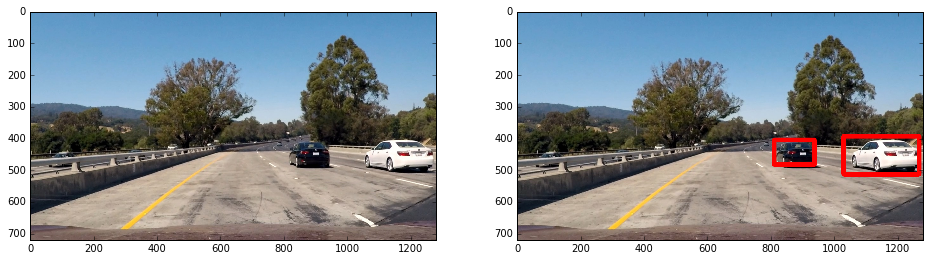

In [19]:
f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
ax1.imshow(image)
ax2.imshow(draw_box(boxes,plt.imread(imagePath),[[500,1280],[300,650]]))

more examples

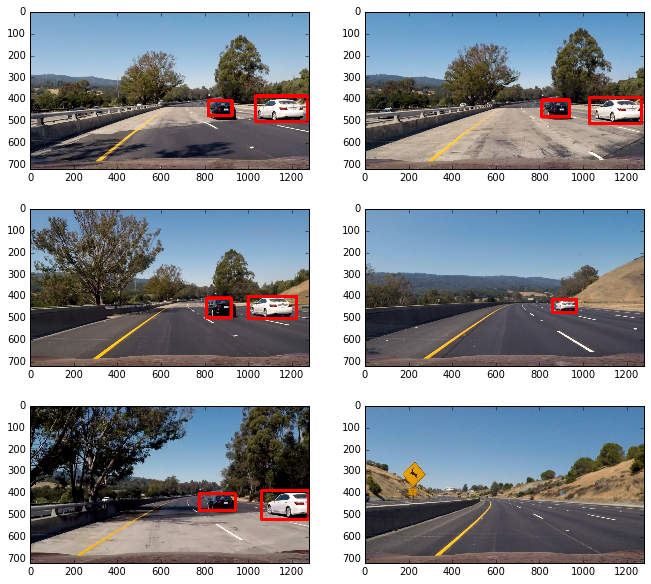

In [20]:
images = [plt.imread(file) for file in glob.glob('./test_images/*.jpg')]
batch = np.array([np.transpose(cv2.resize(image[300:650,500:,:],(448,448)),(2,0,1)) 
                  for image in images])
batch = 2*(batch/255.) - 1
out = model.predict(batch)
f,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3,2,figsize=(11,10))
for i,ax in zip(range(len(batch)),[ax1,ax2,ax3,ax4,ax5,ax6]):
    boxes = yolo_net_out_to_car_boxes(out[i], threshold = 0.17)
    ax.imshow(draw_box(boxes,images[i],[[500,1280],[300,650]]))

## apply to video ##

In [27]:
!pip install moviepy

  Using cached moviepy-0.2.3.2-py2.py3-none-any.whl
  Using cached decorator-4.0.11-py2.py3-none-any.whl
  Using cached tqdm-4.11.2-py2.py3-none-any.whl
  Using cached imageio-2.1.2.zip
  Running setup.py bdist_wheel for imageio ... - done
  Stored in directory: /gpfs/fs01/user/s84a-b0b45068a9ec87-f90433abd686/.cache/pip/wheels/47/a7/c8/2d9d42949793f2ad22a9f7974be42b34f77b97d28aa206cf94
Successfully built imageio


In [ ]:
from moviepy.editor import VideoFileClip

In [21]:
def frame_func(image):
    crop = image[300:650,500:,:]
    resized = cv2.resize(crop,(448,448))
    batch = np.array([resized[:,:,0],resized[:,:,1],resized[:,:,2]])
    batch = 2*(batch/255.) - 1
    batch = np.expand_dims(batch, axis=0)
    out = model.predict(batch)
    boxes = yolo_net_out_to_car_boxes(out[0], threshold = 0.17)
    return draw_box(boxes,image,[[500,1280],[300,650]])

In [ ]:
project_video_output = './project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")

In [24]:
lane_clip = clip1.fl_image(frame_func) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [17:14<00:00,  1.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

Wall time: 17min 15s


In [30]:
HTML("""
<video width="640" height="480" controls>
  <source src="https://github.com/aruizga7/Self-Driving-Car-in-DSX/raw/master/4.%20Vehicle%20detection/project_video_output.mp4">
</video>
""")

## Discussion

The YOLO is known to be fast. In the original paper, the tiny-YOLO is reported to work at nearly 200 FPS on a powerful desktop GPU. In this project, the video is processed on a Nvidia 1070 and the rate is about 21FS without batch processing.

This is a very exciting result. Note that false positives are practically absent. So there is no need at all here for a heatmap, although it certainly could be used to reduce any possible false positives. I vehicle detection with YOLO type networks are an exciting direction to investigate for self-driving cars. Another direction would be to train YOLO on the Udacity training set linked to above. But these will be checked in different projects. Some false positives still remain after heatmap filtering. This should be improvable by using more labeled data.

It would be possible to augment original dataset with 10000 car images and 40000 non-car images from Autti. By changing proportion of original and Autti dataset images in training samples you may fine tune classifier performance. This dataset contains of road images with labeled cars, pedestrians and other road participants. So it is needed to extract car and non-car images from original images. 